# Can you estimate the age of an abalone?

## 📖 Background
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

## 💾 The data
You have access to the following historical data ([source](https://archive.ics.uci.edu/ml/datasets/abalone)):

#### Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

## 💪 Competition challenge
Create a report that covers the following:

1. How does weight change with age for each of the three sex categories?
2. Can you estimate an abalone's age using its physical characteristics? 
3. Investigate which variables are better predictors of age for abalones.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.linear_model import HuberRegressor

from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Helpful formulas

def get_slope(df, x_col, y_col):
    X = sm.add_constant(df[x_col])
    model = sm.OLS(df[y_col], X).fit()
    return model.params[1] 

def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        X_with_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_with_const).fit()
        # Use max p-value
        max_p_value = model.pvalues[1:].max()  # Exclude intercept
        if max_p_value > significance_level:
            excluded_feature = model.pvalues[1:].idxmax()  # Exclude intercept
            features.remove(excluded_feature)
        else:
            break
    return features

def variance_inflation_analysis(X, features):
    X = df[features]
    X = sm.add_constant(X)
    
    # Calculate VIF for each independent variable
    # Variance above 10 is problematic
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values(by = 'VIF', ascending = False).reset_index(drop = True)
    vif_data = vif_data[vif_data['VIF'] > 10]
    vif_data = vif_data[vif_data['feature'] != 'const']

    if vif_data.shape[0] > 0:
        value = vif_data.iloc[0][0]
        return value
    else:
        return vif_data.shape[0]

def complete_regression(df, features, target):
    X = df[features]
    y = df[target]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

def auto_regression(df, features, target):
    check_value = None

    while check_value != 0:
        X = df[features]
        y = df[target]
        model = complete_regression(df, features, target)
        check_value = variance_inflation_analysis(X, features)
        features = [f for f in features if f != check_value]
    return features

In [3]:
data = pd.read_csv('./data/abalone.csv')
data.head()

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         4177 non-null   object 
 1   length      4177 non-null   float64
 2   diameter    4177 non-null   float64
 3   height      4177 non-null   float64
 4   whole_wt    4177 non-null   float64
 5   shucked_wt  4177 non-null   float64
 6   viscera_wt  4177 non-null   float64
 7   shell_wt    4177 non-null   float64
 8   rings       4177 non-null   int64  
 9   age         4177 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 326.5+ KB


# Exploratory Data Analysis

## Relationship among features

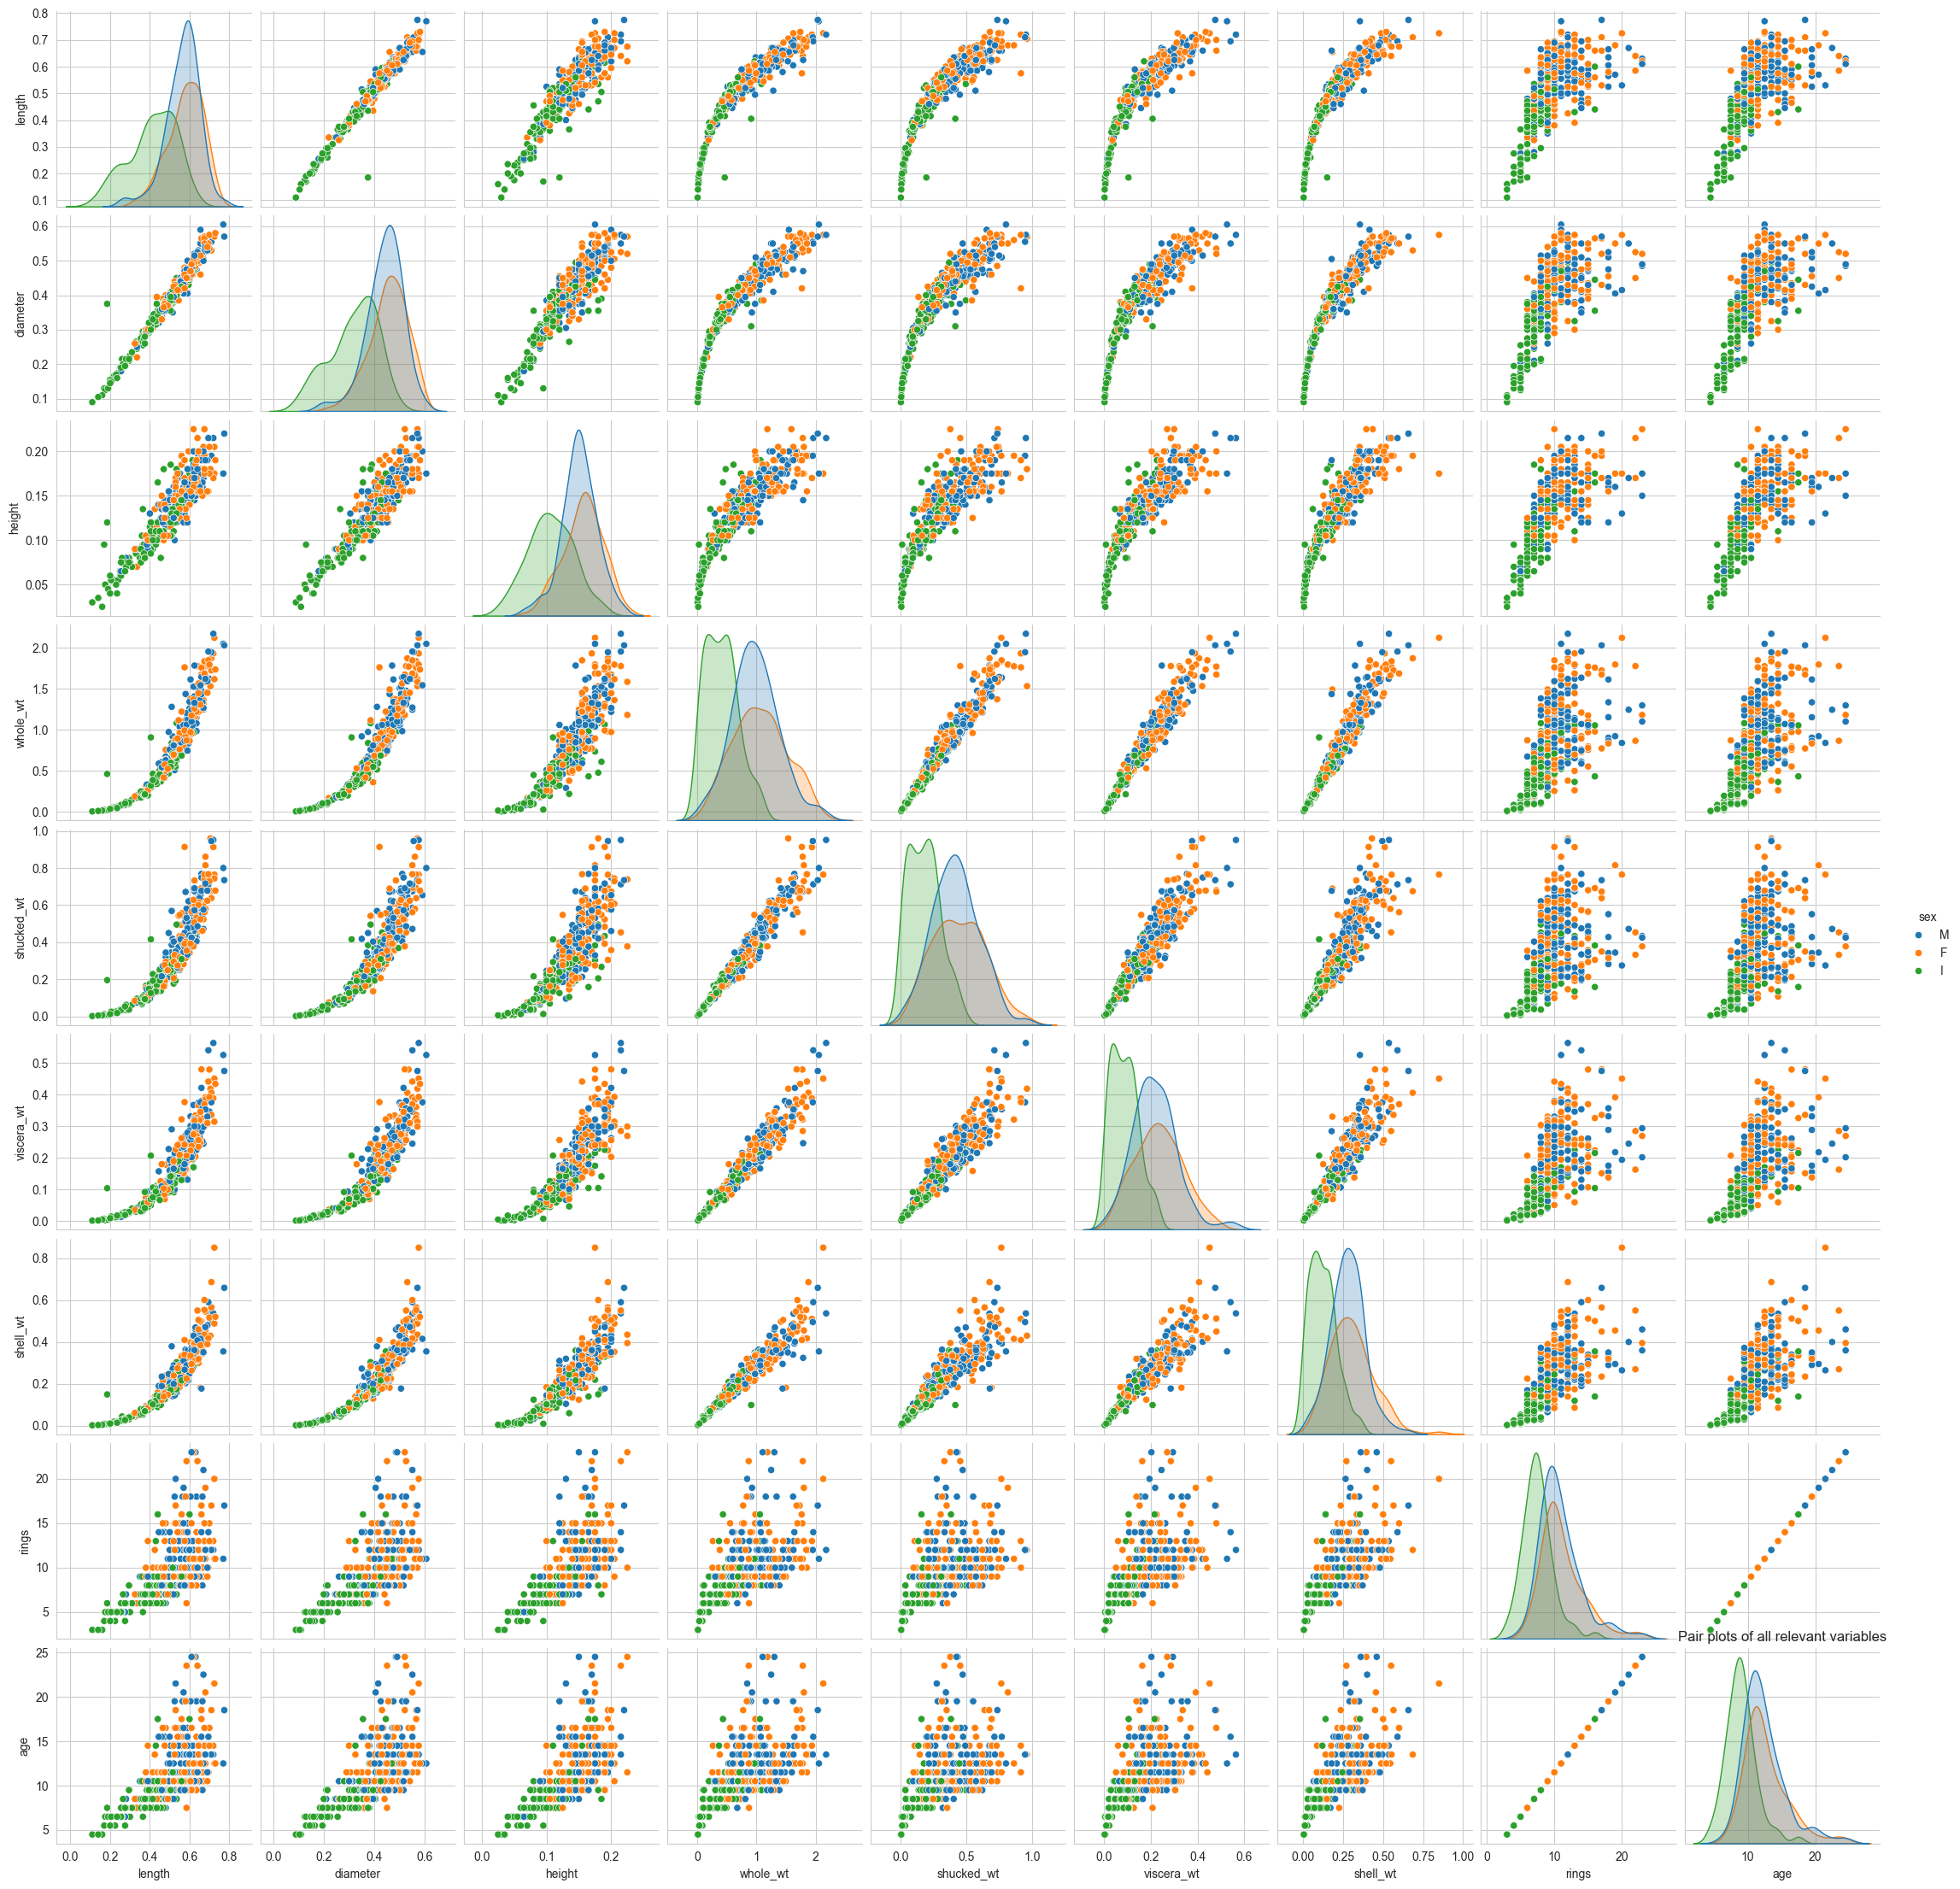

In [5]:
sns.pairplot(
    data = data.sample(frac = 0.10, random_state = 42),
    vars = ['length', 'diameter', 'height', 'whole_wt', 'shucked_wt',
       'viscera_wt', 'shell_wt', 'rings', 'age'],
    hue = 'sex',
    kind = 'scatter',
    diag_kind = 'kde'
)

plt.title("Pair plots of all relevant variables")
plt.show()

## Relationship between weight, age, and sex

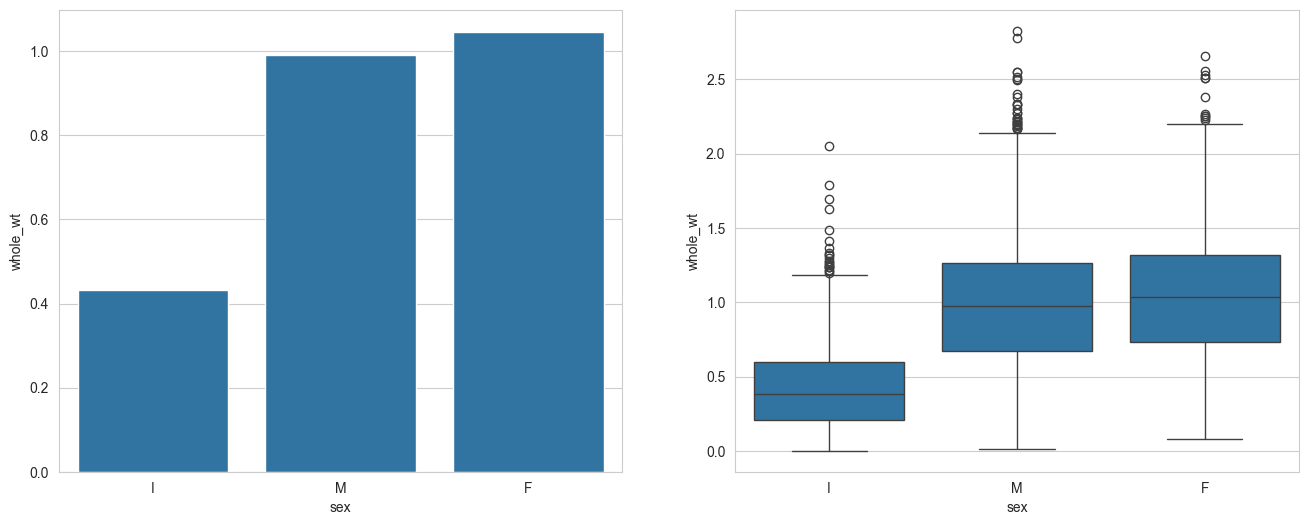

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
sns.barplot(data = data, x = 'sex', y = 'whole_wt', errorbar = None, order = ['I','M','F'], ax = axs[0])
sns.boxplot(data = data, x = 'sex', y = 'whole_wt', order=['I','M','F']);

# Q1: How does weight change with age for each of the three sex categories?

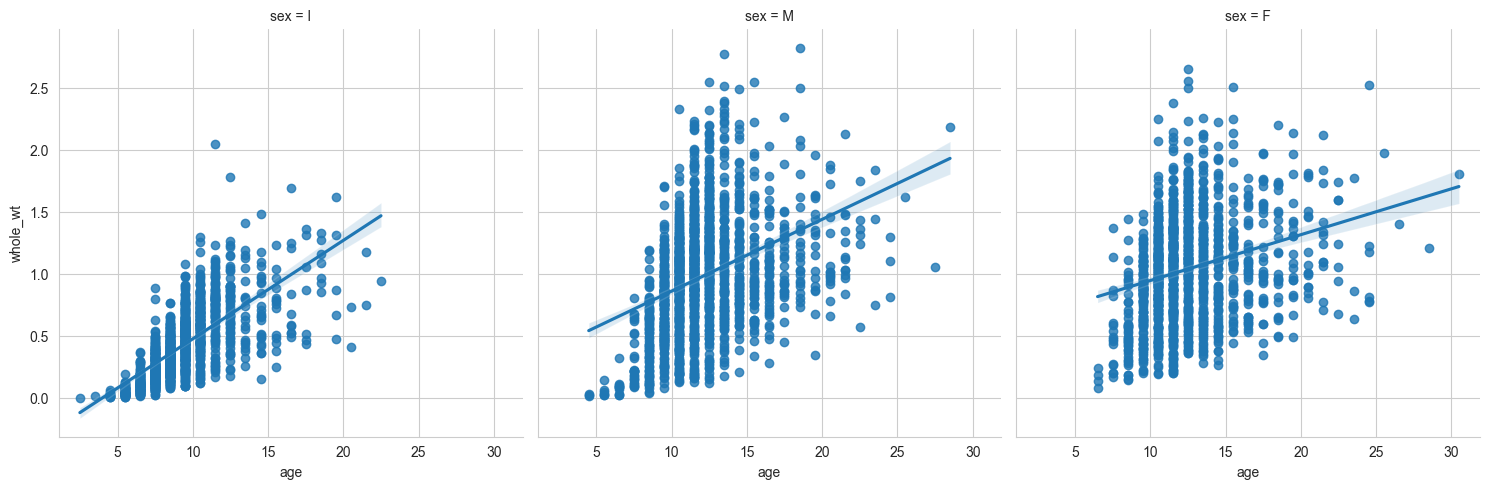

In [7]:
g = sns.FacetGrid(data = data, col='sex', height = 5, col_order=['I','M','F'])
g = g.map(sns.regplot, 'age', 'whole_wt')
plt.tight_layout()

## Answer

In [8]:
results = data.groupby('sex').apply(get_slope, 'age', 'whole_wt').reset_index()
results.columns = ['sex', 'slope']
for i, row in results.iterrows():
    print(f"For every 1-year increase in abalone age, the weight of {row['sex']}-gender abalones increases by {round(row['slope'], 3)} on average.")

For every 1-year increase in abalone age, the weight of F-gender abalones increases by 0.037 on average.
For every 1-year increase in abalone age, the weight of I-gender abalones increases by 0.079 on average.
For every 1-year increase in abalone age, the weight of M-gender abalones increases by 0.058 on average.


# Q2: Can you estimate an abalone's age using its physical characteristics?

## Drop the 'Rings' feature

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope.is somewhat cumbersome. We need to estimate the age of the abalone using physical characteristics alone.

In [9]:
df = data.drop('rings', axis = 1)
df = pd.get_dummies(df, drop_first=True)
df.head()

,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,age,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,1,0


## Drop outliers

There were some huge abalones (i.e. they were significantly larger in height) that impact later-stage model building

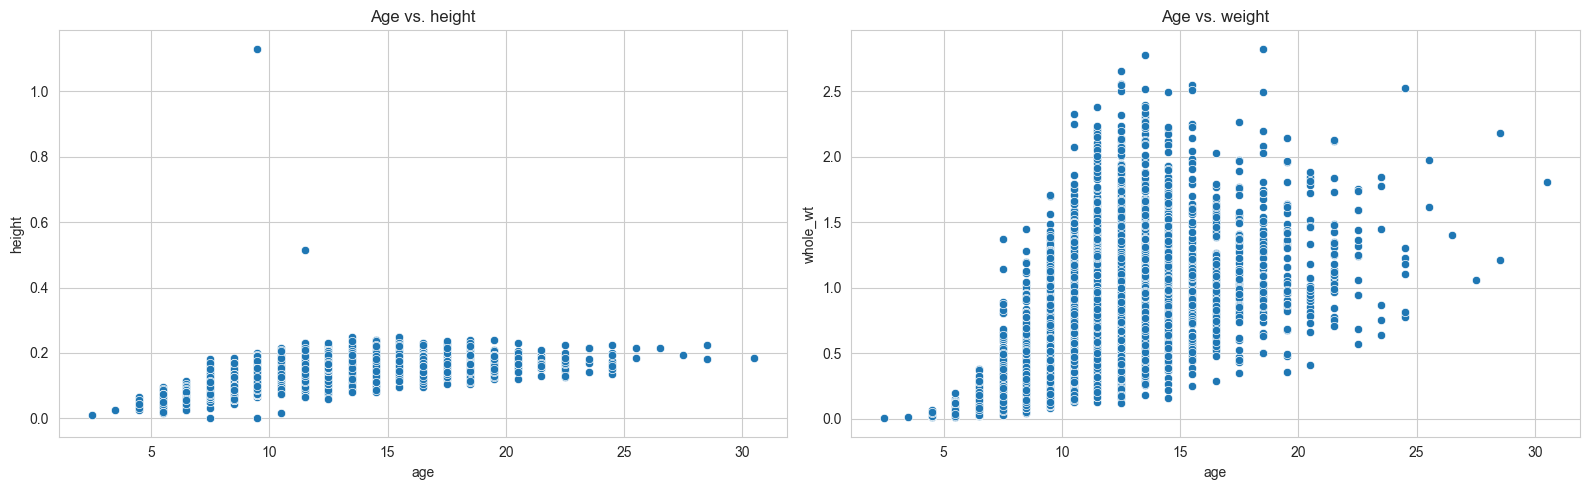

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
sns.scatterplot(data = df, y = 'height', x = 'age', ax = axs[0])
sns.scatterplot(data = df, y = 'whole_wt', x = 'age', ax = axs[1])
axs[0].set_title("Age vs. height")
axs[1].set_title("Age vs. weight")
plt.tight_layout()

In [11]:
df = df[df['height'] < 0.4].reset_index(drop = True)

## Check for multicollinearity

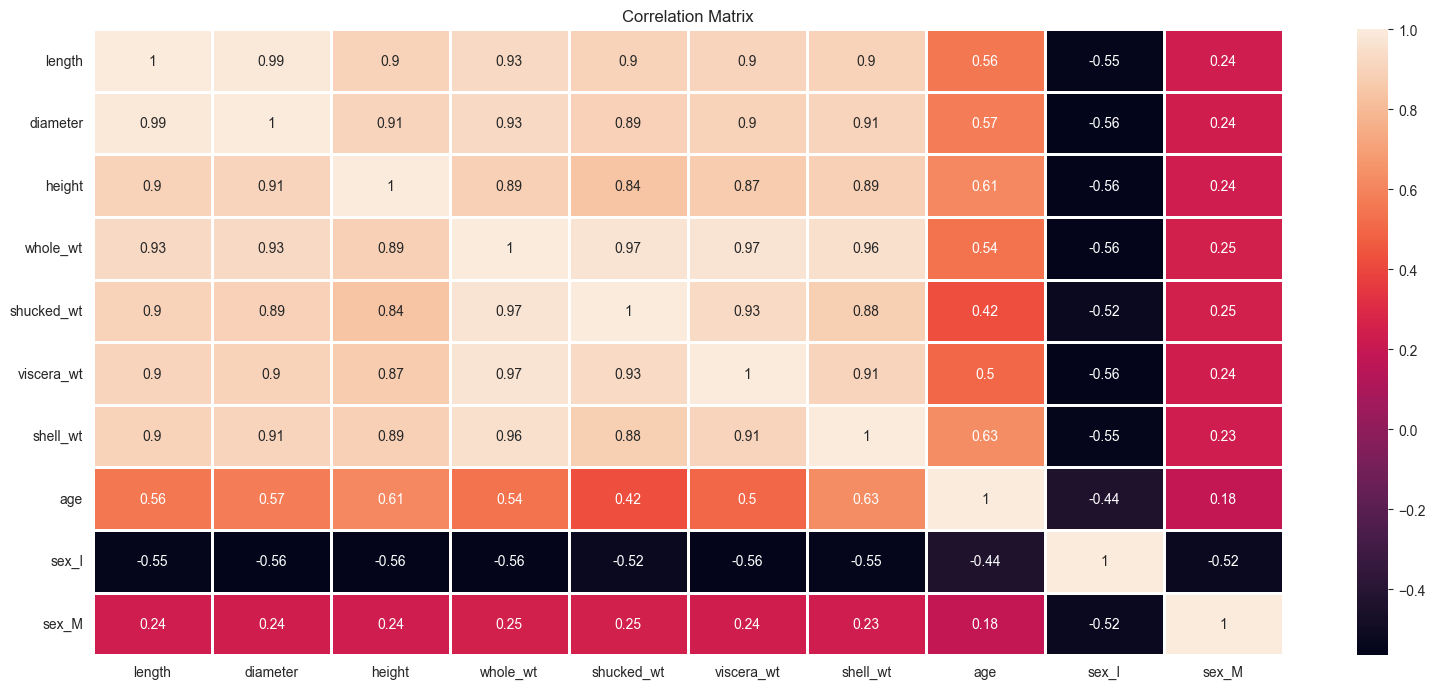

In [12]:
plt.figure(figsize = (16, 7))
sns.heatmap(df.corr(), annot = True, linewidths=2)
plt.title("Correlation Matrix")
plt.tight_layout()

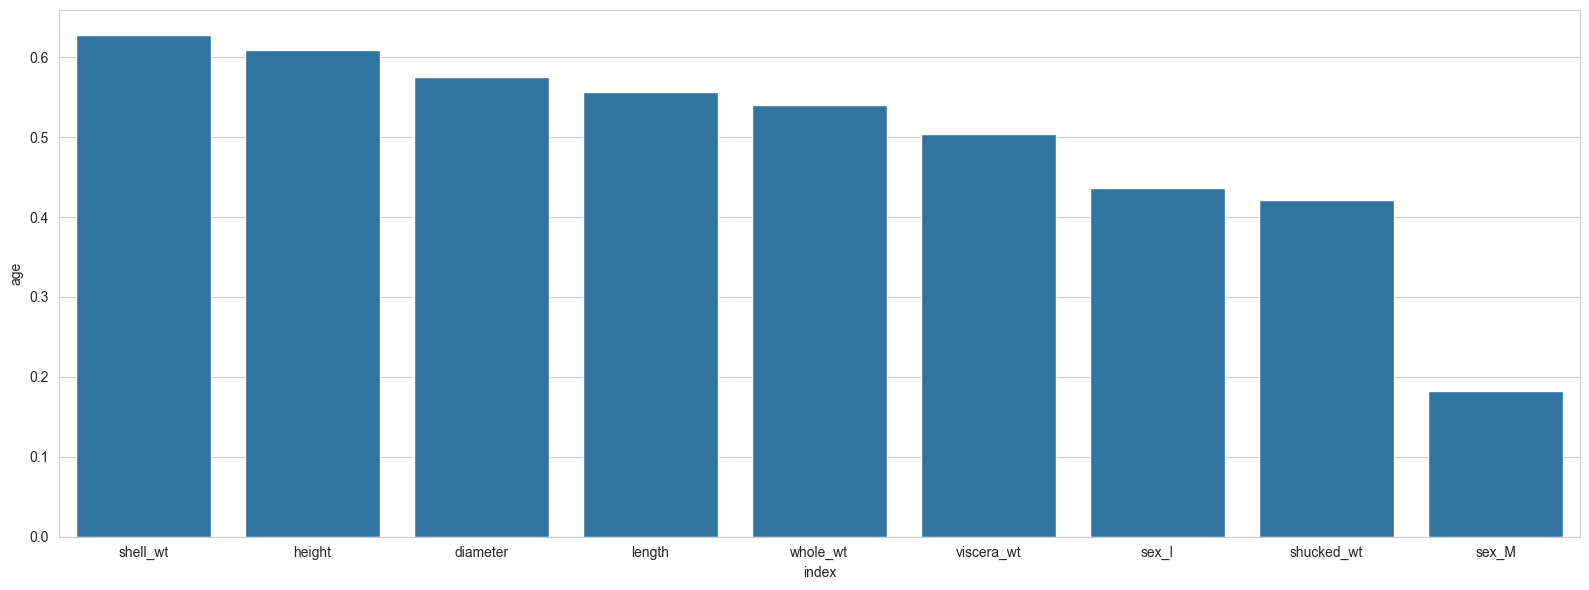

In [13]:
plt.figure(figsize = (16, 6))
tmp = df.corr(numeric_only = False)['age'].reset_index()
tmp['age'] = tmp['age'].apply(np.abs)
tmp = tmp.sort_values(by = 'age', ascending = False)
tmp = tmp[~tmp['index'].isin(['age'])]
sns.barplot(data = tmp, x = 'index', y = 'age')
plt.tight_layout()

## Removing correlated features

In [14]:
features = ['length', 'diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt', 'sex_I', 'sex_M']
new_features = auto_regression(df, features, 'age')
print(f"Features to keep: {new_features}")
model = complete_regression(df, new_features, 'age')
model.summary()

Features to keep: ['length', 'height', 'shucked_wt', 'shell_wt', 'sex_I', 'sex_M']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     767.6
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        13:25:28   Log-Likelihood:                -9258.2
No. Observations:                4175   AIC:                         1.853e+04
Df Residuals:                    4168   BIC:                         1.857e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0419      0.295     17.064      0.000       4.463       5.621
length         5.3286      0.854      6.242      0.000       3.655       7.002
height        25.1879      2.281     11.043      0.000      20.716      29.660
shucked_wt   -11.4885      0.386    -29.785      0.000     -12.245     -10.732
shell_wt      18.7641      0.669     28.062      0.000      17.453      20.075
sex_I         -0.8614      0.103     -8.393      0.000      -1.063      -0.660
sex_M          0.0469      0.084      0.556      0.578      -0.118       0.212
==============================================================================
Omnibus:                     1058.711   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3241.466
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                       6.456   Cond. No.                         89.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Residual Normality

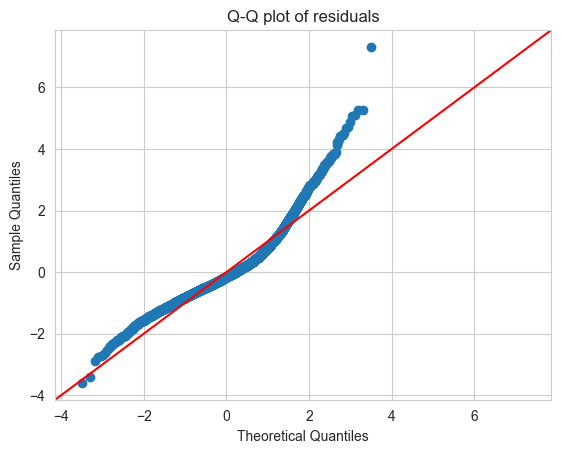

Shapiro-Wilk Test - Statistic: 0.9203423857688904 , P-value: 1.9590152531260943e-42


In [15]:
# Q-Q plot
fig = sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q plot of residuals')
plt.show()

# Shapiro-Wilk test
stat, p_value = shapiro(model.resid)
print('Shapiro-Wilk Test - Statistic:', stat, ', P-value:', p_value)

## Performing log transformation of target variable

In [16]:
df1 = df.copy()
df1['ln_age'] = np.log(df['age'])
df1 = df1.drop('age', axis = 1)

In [17]:
new_features = auto_regression(df1, features, 'ln_age')
model = complete_regression(df1, new_features, 'ln_age')

## Removing features with low explanatory power (< 0.05)

In [18]:
X = df1[new_features]
y = df1['ln_age']

best_features = backward_elimination(X, y)

In [19]:
model = complete_regression(df1, best_features, 'ln_age')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ln_age   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1188.
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        13:25:29   Log-Likelihood:                 1351.2
No. Observations:                4175   AIC:                            -2690.
Df Residuals:                    4169   BIC:                            -2652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6498      0.023     72.849      0.000       1.605       1.694
length         0.9955      0.067     14.820      0.000       0.864       1.127
height         2.3277      0.180     12.960      0.000       1.976       2.680
shucked_wt    -0.9547      0.030    -31.515      0.000      -1.014      -0.895
shell_wt       1.1474      0.053     21.798      0.000       1.044       1.251
sex_I         -0.0848      0.007    -11.967      0.000      -0.099      -0.071
==============================================================================
Omnibus:                      266.906   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.086
Skew:                           0.580   Prob(JB):                     1.29e-77
Kurtosis:                       3.830   Cond. No.                         85.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Assessing Model Homoscedasticity

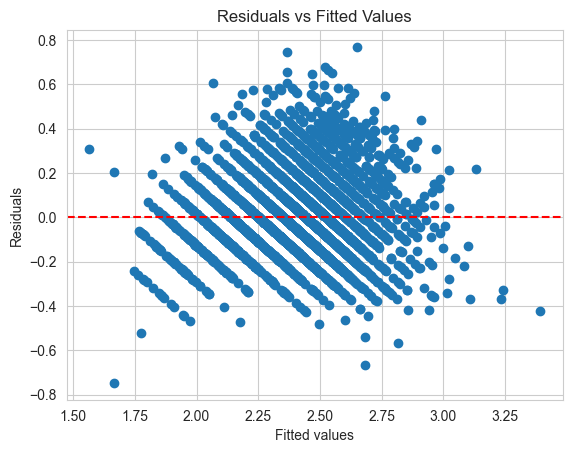

{'Lagrange Multiplier statistic': 164.0181767786442, 'p-value': 1.3771500281343137e-33, 'f-value': 34.09597994343401, 'f p-value': 2.963914873485737e-34}


In [20]:
# Residuals vs Fitted values plot
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

In [21]:
robust_model = model.get_robustcov_results(cov_type = 'HC0')

In [22]:
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ln_age   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1032.
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        13:25:29   Log-Likelihood:                 1351.2
No. Observations:                4175   AIC:                            -2690.
Df Residuals:                    4169   BIC:                            -2652.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6498      0.026     64.665      0.000       1.600       1.700
length         0.9955      0.073     13.722      0.000       0.853       1.138
height         2.3277      0.201     11.556      0.000       1.933       2.723
shucked_wt    -0.9547      0.036    -26.808      0.000      -1.024      -0.885
shell_wt       1.1474      0.065     17.668      0.000       1.020       1.275
sex_I         -0.0848      0.007    -11.678      0.000      -0.099      -0.071
==============================================================================
Omnibus:                      266.906   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.086
Skew:                           0.580   Prob(JB):                     1.29e-77
Kurtosis:                       3.830   Cond. No.                         85.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

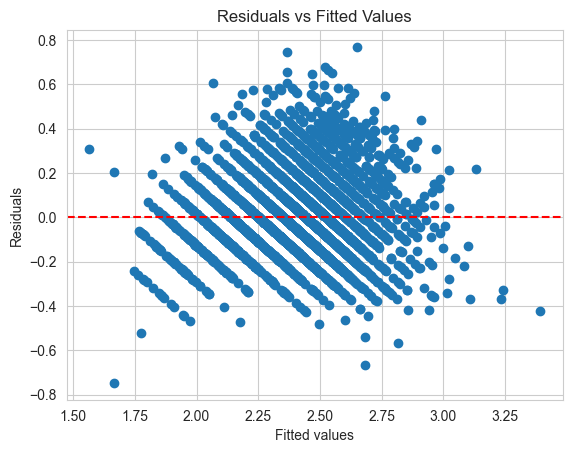

{'Lagrange Multiplier statistic': 164.0181767786442, 'p-value': 1.3771500281343137e-33, 'f-value': 34.09597994343401, 'f p-value': 2.963914873485737e-34}


In [23]:
# Residuals vs Fitted values plot
plt.scatter(robust_model.fittedvalues, robust_model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(robust_model.resid, robust_model.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

# Investigate which variables are better predictors of age for abalones.

## Answer

In [24]:
print("The better predictors of age for abalones include:")
for feature in best_features:
    print(f"- {feature}")

The better predictors of age for abalones include:
- length
- height
- shucked_wt
- shell_wt
- sex_I


## Predict the age of an abalone using linear regression

In [27]:
length = 0.70
height = 0.16
shucked_wt = 0.36
shell_wt = 0.25
sex_I = 0

print(f"This abalone with these qualities is predicted to be {round(model.predict([1, length, height, shucked_wt, shell_wt, sex_I])[0], 2)} years old.")

This abalone with these qualities is predicted to be 2.66 years old.
